In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import pytorch_lightning as pl

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [29]:
%conda update ffmpeg

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::matplotlib-base==3.5.0=py39h3ed280b_0
  - conda-forge/noarch::jupyterlab_pygments==0.1.2=pyh9f0ad1d_0
  - defaults/linux-64::pip==21.1.3=py39h06a4308_0
  - conda-forge/noarch::notebook==6.4.6=pyha770c72_0
  - conda-forge/noarch::pygments==2.11.2=pyhd8ed1ab_0
  - defaults/linux-64::scipy==1.7.3=py39hc147768_0
  - defaults/linux-64::mkl_fft==1.3.1=py39hd3c417c_0
  - conda-forge/noarch::bleach==4.1.0=pyhd8ed1ab_0
  - pyg/linux-64::pytorch-sparse==0.6.12=py39_torch_1.10.0_cu113
  - conda-forge/linux-64::ipykernel==5.5.5=py39hef51801_0
  - conda-forge/linux-64::ipython==7.31.0=py39hf3d152e_0
  - conda-forge/noarch::prompt-toolkit==3.0.24=pyha770c72_0
  - conda-forge/noarch::backports.functools_lru_cache==1.6.4=pyhd8ed1ab_0
  - defaults/linux-64::bottleneck==1.3.2=py39hdd57654_1
  - conda-forge/noarch::networkx==2.6.3=p

attrs-21.4.0         | 51 KB     | ##################################### | 100% 
argon2-cffi-bindings | 33 KB     | ##################################### | 100% 
urllib3-1.26.8       | 106 KB    | ##################################### | 100% 
expat-2.4.4          | 169 KB    | ##################################### | 100% 
backports-1.1        | 4 KB      | ##################################### | 100% 
six-1.16.0           | 18 KB     | ##################################### | 100% 
pandoc-2.12          | 9.5 MB    | ##################################### | 100% 
libwebp-1.2.2        | 80 KB     | ##################################### | 100% 
glib-2.69.1          | 1.7 MB    | ##################################### | 100% 
cffi-1.15.0          | 225 KB    | ##################################### | 100% 
argon2-cffi-21.3.0   | 15 KB     | ##################################### | 100% 
openssl-1.1.1m       | 2.5 MB    | ##################################### | 100% 
kiwisolver-1.3.2     | 80 KB

In [3]:
import configuration
import data.constants as dconstants
import model.constants as mconstants
from data.build import load_data_from_configuration, load_base_data_from_configuration
from model.build import make_model
from data.util import data_get_num_attributes, data_get_num_classes
from train import train_model
from data.transform import PerturbationTransform
from torch_geometric.loader import DataLoader
import umap
from openTSNE import TSNE
from model.density import get_density_model
from model.prediction import SOFT_PREDICTIONS
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import seed

In [4]:
import logging 
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [5]:
import tempfile

spectrum_fn = tempfile.NamedTemporaryFile(suffix='.pkl')
spectrum_fn.name

'/tmp/tmpvfpouz1v.pkl'

In [6]:
data_cfg = configuration.DataConfiguration(
                        dataset=dconstants.CORA_FULL, 
                        train_portion=20, test_portion_fixed=0.2,
                        ood_type = dconstants.PERTURBATION,
                        setting = dconstants.HYBRID,
                        drop_train_vertices_portion = 0.1,
                        preprocessing='none'
                        )

In [7]:
spectral_norm_cfg = {
        'use_spectral_norm' : True,
        'residual' : True,
        'weight_scale' : 10.0,
    }


model_cfg = configuration.ModelConfiguration(
        model_type=mconstants.GCN,
        hidden_sizes=[64,], 
        use_bias=True, 
        activation='leaky_relu', 
        leaky_relu_slope=0.01,
        freeze_residual_projection=False, 
        use_spectral_norm_on_last_layer=True,
        use_residual_on_last_layer=False,
        self_loop_fill_value=1.0, 
        cached=True,
        **spectral_norm_cfg,
        # residual=True,
        )
if not model_cfg.use_spectral_norm:
    model_cfg.use_spectral_norm_on_last_layer = False

training_cfg = configuration.TrainingConfiguration(
        max_epochs=1000, # 1000, 
        learning_rate=0.001, 
        early_stopping={
            'monitor' : 'val_loss',
            'mode' : 'min',
            'patience' : 50,
            'min_delta' : 1e-2,
        }, 
        gpus=1, 
        suppress_stdout=False, 
        weight_decay=1e-3,
        )
logging_cfg = configuration.LoggingConfiguration(
    log_weight_matrix_spectrum_every = 1,
    log_weight_matrix_spectrum_to_file = spectrum_fn.name,
)


cfg = configuration.ExperimentConfiguration(model=model_cfg, data=data_cfg, training=training_cfg, logging=logging_cfg)

In [8]:
cfg.model

ModelConfiguration(hidden_sizes=[64], linear_classification=False, weight_scale=10.0, use_spectral_norm=True, model_type='gcn', use_bias=True, activation='leaky_relu', leaky_relu_slope=0.01, residual=True, residual_pre_activation=True, freeze_residual_projection=False, dropout=0.0, drop_edge=0.0, use_spectral_norm_on_last_layer=True, use_residual_on_last_layer=False, cached=True, self_loop_fill_value=1.0, reconstruction=ReconstructionConfiguration(loss_weight=0.0, sample=True, num_samples=100, seed=1337, reconstruction_type='autoencoder', cached=True, margin_constrastive_loss=0.0), feature_reconstruction=FeatureReconstructionConfiguration(loss_weight=0.0, loss='l2', mirror_encoder=True, activation_on_last_layer=False, log_metrics_every=1, num_samples=-1, seed=1337), gat=None, appnp=None, bgcn=None, laplace=None, input_distance=None, gdk=None)

In [9]:
configuration.update_with_default_configuration(cfg)

INFO:root:Set configuration value data.base_labels to default ['Artificial_Intelligence/Machine_Learning/Case-Based', 'Artificial_Intelligence/Machine_Learning/Theory', 'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms', 'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods', 'Artificial_Intelligence/Machine_Learning/Neural_Networks', 'Artificial_Intelligence/Machine_Learning/Rule_Learning', 'Artificial_Intelligence/Machine_Learning/Reinforcement_Learning', 'Operating_Systems/Distributed', 'Operating_Systems/Memory_Management', 'Operating_Systems/Realtime', 'Operating_Systems/Fault_Tolerance']
INFO:root:Set configuration value data.corpus_labels to default ['Artificial_Intelligence/Machine_Learning/Case-Based', 'Artificial_Intelligence/Machine_Learning/Theory', 'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms', 'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods', 'Artificial_Intelligence/Machine_Learning/Neural_Networks', 'Artificial_Intell

In [10]:
# cfg.data.preprocessing = 'bag_of_words'

In [11]:
model_seed_generator = iter(seed.SeedIterator(seed.model_seeds()[cfg.run.initialization_idx]))
model_seed = next(model_seed_generator)
data_split_seed = seed.data_split_seeds()[cfg.run.split_idx]

In [12]:

cfg.registry.split_seed = data_split_seed
cfg.registry.model_seed = model_seed

In [13]:
print(data_split_seed, model_seed)

2612666288 1952926171


In [14]:

datasets, _ = load_data_from_configuration(cfg.data, cfg.registry.split_seed)

INFO:root:Data Loading - Loaded adjacency matrix.
INFO:root:Data Loading - Built attribute matrix.


In [15]:
datasets[dconstants.TRAIN][0].x.size()

torch.Size([2125, 8710])

In [16]:
datasets[dconstants.TRAIN][0].x.norm(dim=-1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])

In [17]:
pl.seed_everything(cfg.registry.model_seed)
model = make_model(cfg, data_get_num_attributes(datasets[dconstants.TRAIN][0]), 
                data_get_num_classes(datasets[dconstants.TRAIN][0])) 

Global seed set to 1952926171


In [18]:
data_loaders = {
            name : DataLoader(data, batch_size=1, shuffle=False) for name, data in datasets.items()
        }

In [19]:
cfg.run.use_pretrained_model = False

In [20]:
cfg.run.use_pretrained_model

False

In [21]:
model = train_model(model, cfg, '~', data_loaders, logger=None).eval().cpu()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name     | Type | Params
----------------------------------
0 | backbone | GCN  | 1.1 M 
----------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.462     Total estimated model params size (MB)
Global seed set to 1952926171
INFO:root:Paths ['/nfs/students/fuchsgru/model_registry/1570779289.ckpt'] were overwritten with /nfs/homedirs/fuchsgru/MastersThesis/~/epoch=19-step=19-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.8142856955528259,
 'val_cross_entropy': 0.6735990047454834,
 'val_loss': 0.6735990047454834}
--------------------------------------------------------------------------------


In [22]:
model.clear_and_disable_cache()

INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


In [23]:
import pickle
with open(spectrum_fn.name, 'rb') as f:
    spectrum = pickle.load(f)

In [24]:
spectrum.keys()

dict_keys(['backbone.convs.0.conv.lin.parametrizations.weight.original', 'backbone.convs.0.input_projection.linear.parametrizations.weight.original', 'backbone.convs.1.conv.lin.parametrizations.weight.original'])

(0.0, 63.0)

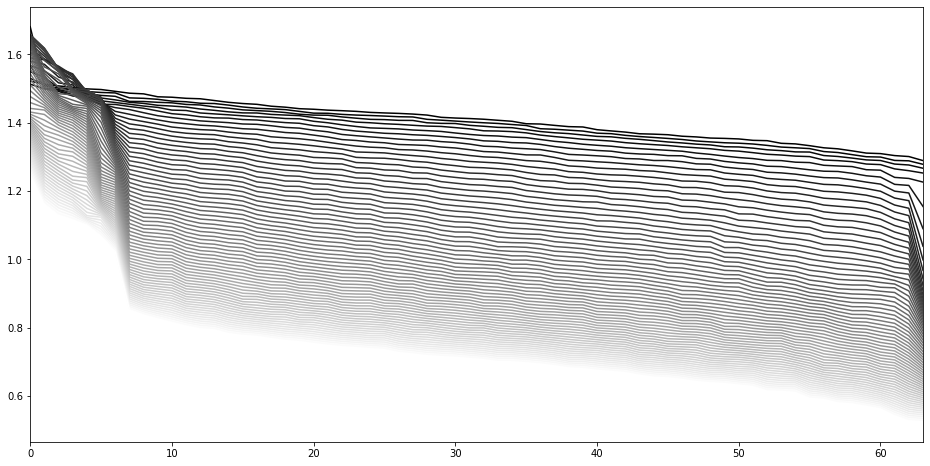

In [26]:
svs = np.array(spectrum['backbone.convs.0.conv.lin.parametrizations.weight.original'])

fig, ax = plt.subplots(figsize=(16, 8))
colors = np.linspace(0.0, 1.0, svs.shape[0])
for idx, magnitude in enumerate(colors):
    plt.plot(np.arange(svs.shape[1]), svs[idx], c=np.ones(3) * magnitude)
ax.set_xlim(0, svs.shape[1] - 1)

<AxesSubplot:xlabel='Epoch', ylabel='Singular Value'>

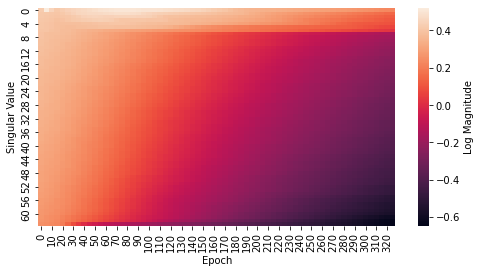

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))
df = pd.DataFrame(np.log(svs.T), columns=5 * np.arange(svs.shape[0]))
df.index.name = 'Singular Value'
df.columns.name = 'Epoch'
sns.heatmap(df, ax=ax, cbar_kws={'label': 'Log Magnitude'})

In [28]:
svs[-1]

array([1.2479631 , 1.1594712 , 1.1259974 , 1.1134923 , 1.099673  ,
       1.0659798 , 1.0220399 , 0.8515842 , 0.836437  , 0.82472134,
       0.8134951 , 0.8037798 , 0.79525465, 0.7923918 , 0.78141934,
       0.77620894, 0.7735933 , 0.76697856, 0.7614575 , 0.7577314 ,
       0.75211495, 0.7473928 , 0.74304116, 0.74053794, 0.73742586,
       0.7345955 , 0.7261348 , 0.7219736 , 0.71731687, 0.71406513,
       0.7120806 , 0.70884246, 0.70570123, 0.6997358 , 0.6991552 ,
       0.6964134 , 0.6925111 , 0.68770856, 0.68143874, 0.6791488 ,
       0.6740932 , 0.6711245 , 0.6674653 , 0.6601023 , 0.65420014,
       0.6523135 , 0.6476725 , 0.6415725 , 0.6381267 , 0.6355922 ,
       0.63119066, 0.6269822 , 0.61385274, 0.61260253, 0.60914415,
       0.59221196, 0.58914196, 0.5791829 , 0.5759473 , 0.5691679 ,
       0.561591  , 0.5409634 , 0.5262111 , 0.5239349 ], dtype=float32)

In [ ]:
import matplotlib.animation as animation

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))

In [ ]:
line, = ax.plot(svs[0])

In [ ]:
def animate(i):
    line.set_ydata(svs[i])  # update the data.
    return line,


ani = animation.FuncAnimation(fig, animate, interval=20, blit=True, save_count=50)

In [ ]:
writer = animation.FFMpegWriter(
     fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save("movie.mp4", writer=writer)

In [ ]:
fig